In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.append('/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/')

from dNdS_analysis.utils import dynamics_utils
import dNdS_analysis.config as config

In [2]:
complete_df = dynamics_utils.load_dNdS_data()

# filter for pairs that are clonal
clonal_mask = complete_df['recomb_len_4D'].isna()
passed_pairs = complete_df[clonal_mask]

In [3]:
passed_pairs.index.get_level_values('species_name').value_counts()

species_name
Bacteroides_caccae_53434              173
Bacteroides_uniformis_57318           121
Bacteroides_stercoris_56735            68
Parabacteroides_merdae_56972           65
Bacteroides_vulgatus_57955             57
Bacteroides_ovatus_58035               48
Bacteroides_massiliensis_44749         39
Bacteroides_eggerthii_54457            37
Bacteroides_finegoldii_57739           14
Bacteroides_cellulosilyticus_58046     13
Parabacteroides_distasonis_56985       13
Barnesiella_intestinihominis_62208     11
Alistipes_sp_60764                      9
Bacteroides_fragilis_54507              9
Phascolarctobacterium_sp_59817          9
Bacteroides_thetaiotaomicron_56941      7
Akkermansia_muciniphila_55290           6
Alistipes_onderdonkii_55464             1
Alistipes_putredinis_61533              1
Ruminococcus_bromii_62047               1
Oscillibacter_sp_60799                  1
Name: count, dtype: int64

In [4]:
from dNdS_analysis.utils import snv_utils

def dedup_clonal_pairs(pairs_df, snv_helper=None, identical_frac_threshold=0.2):
    if snv_helper is None:
        snv_helper = snv_utils.SNVHelper(pairs_df.index.get_level_values('species_name').unique()[0], compute_bi_snvs=False, annotate=True)
        snv_helper.load_identical_block()
    included_pairs = []
    for pair, row in pairs_df.iterrows():
        # check if pair is close to any of the included pairs
        close_to_included = False
        pair = (str(pair[0]), str(pair[1]))
        for included_pair in included_pairs:
            sample1 = included_pair[0]
            sample2 = pair[0]
            dist = snv_helper.identical_block_frac.loc[sample1, sample2]
            if dist > identical_frac_threshold:
                close_to_included = True
                break
        # if not close to any included pair, add it
        if not close_to_included:
            included_pairs.append(pair)
        else:
            continue
    return included_pairs

In [5]:
# find clonal pairs per species
species_name = 'Bacteroides_vulgatus_57955'
species_clonal_pairs = passed_pairs.loc[species_name]

# then keep one pair per clonal cluster
snv_helper = snv_utils.SNVHelper(species_name, compute_bi_snvs=False, annotate=True)
snv_helper.load_identical_block()

# then filter to only one pair per clonal cluster 
dedup_pairs = dedup_clonal_pairs(species_clonal_pairs, snv_helper)

In [6]:
clades = pd.read_csv('/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/data/Bv_clades.txt', sep='\t',index_col=0, header=None, names=['sample','clade'])
major_clade_samples = clades[clades['clade'] == 'major'].index

dedup_pairs = [pair for pair in dedup_pairs if pair[0] in major_clade_samples]

# Trying to build up an unrelated sample set

In [7]:
# start with the clonal samples
samples1 = set(species_clonal_pairs.index.get_level_values('sample 1'))
samples2 = set(species_clonal_pairs.index.get_level_values('sample 2'))
clonal_samples = list(samples1.union(samples2))
print(len)

<built-in function len>


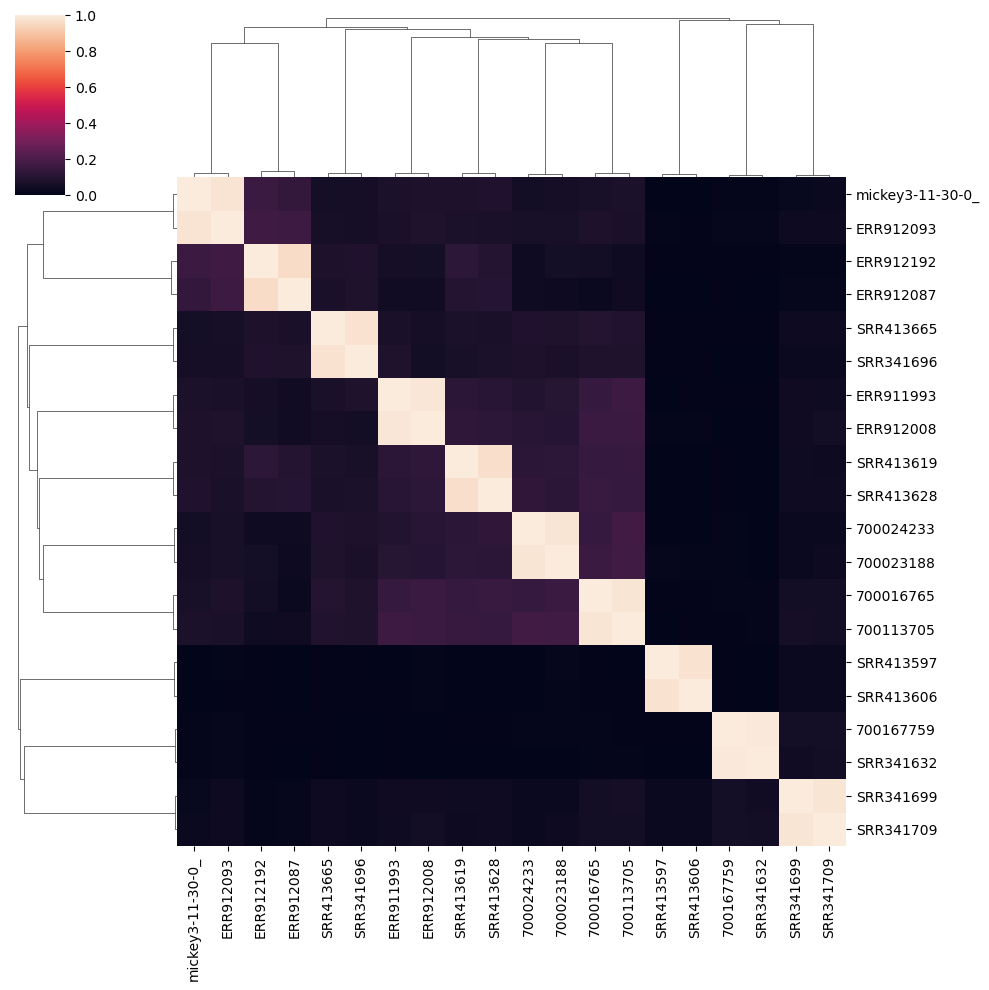

In [8]:
samples = [x for tup in dedup_pairs for x in tup]
unique_samples = list(set(samples))

sns.clustermap(snv_helper.identical_block_frac.loc[unique_samples, unique_samples],)

In [9]:
included_samples = [sample for sample in unique_samples if sample in major_clade_samples]
for sample in major_clade_samples:
    if sample in included_samples:
        continue
    # then check the distance to the included samples
    # access the identical block fraction matrix directly
    similarity = snv_helper.identical_block_frac.loc[included_samples, sample]
    # if any similarity is greater than 0.5, skip the sample
    if similarity.max() < 0.5:
        included_samples.append(sample)
        continue

print(len(dedup_pairs))
print(len(included_samples))

10
120


/Users/Device6/miniforge3/envs/dNdS_310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/Device6/miniforge3/envs/dNdS_310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


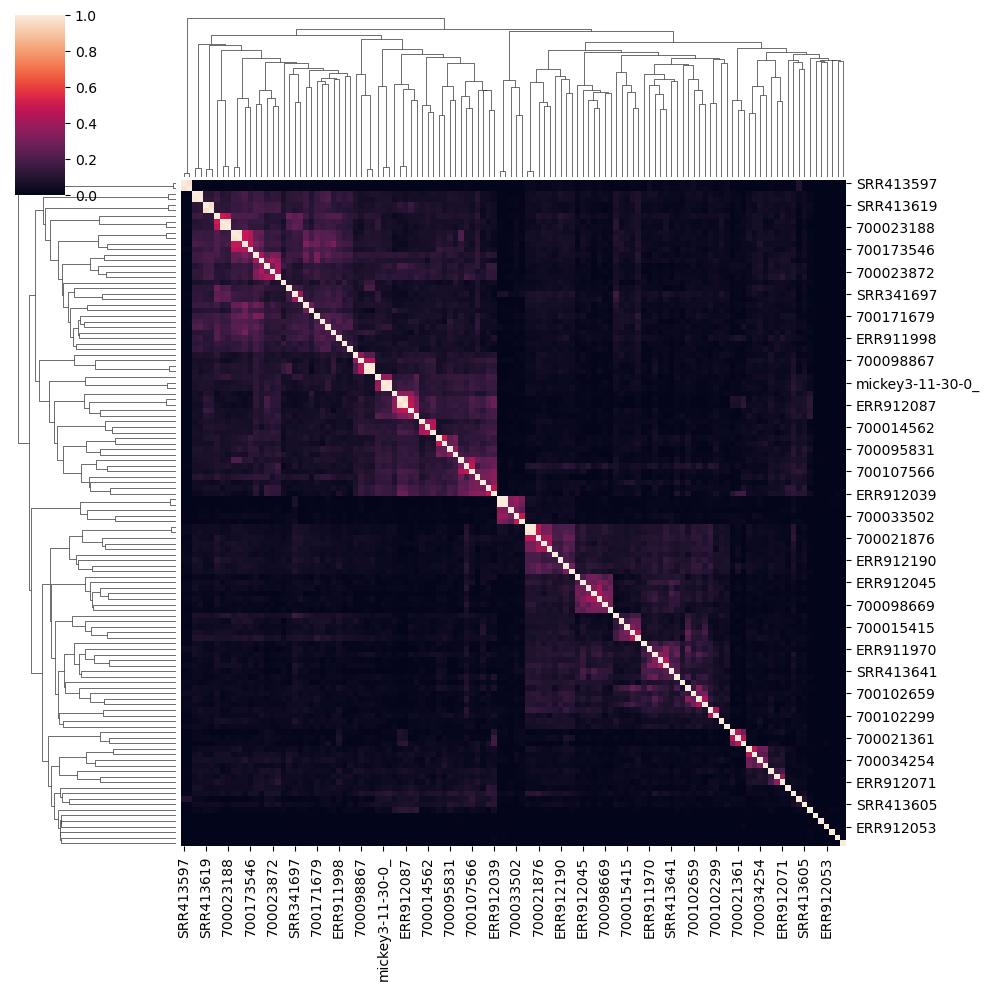

In [10]:
sns.clustermap(snv_helper.identical_block_frac.loc[included_samples, included_samples],)

# Analyze clonal homoplasy

In [11]:
def repolarize_counts(alts, covs):
    m = alts > (covs / 2)
    alts = alts.copy()
    alts[m] = covs[m] - alts[m]
    return alts

In [12]:
def compute_snv_stats(snv_helper, clonal_pairs, included_samples):
    # Identify clonal SNVs
    all_clonal_diffs = pd.DataFrame(index=snv_helper.snvs.index)
    # dedup pairs are unique clonal pairs with no other clonal strains
    for pair in clonal_pairs:
        pair_snvs = snv_helper.compute_pairwise_snvs(pair[0], pair[1])
        all_clonal_diffs[pair] = pair_snvs
    clonal_snvs = all_clonal_diffs[all_clonal_diffs.sum(axis=1)>0]

    haps_all = snv_helper.snvs.loc[:, included_samples]
    num_alt_all = (haps_all==1).sum(axis=1)
    num_covered_all = (haps_all!=255).sum(axis=1)
    snv_filter = (num_alt_all > 0) & (num_alt_all < num_covered_all)
    haps_all = haps_all.loc[snv_filter, :]
    num_alt_all = num_alt_all[snv_filter]
    num_covered_all = num_covered_all[snv_filter]

    # next focusing on subset of snvs that are detected between clonal pairs
    haps = haps_all.loc[clonal_snvs.index, :]
    num_alt = (haps==1).sum(axis=1)
    num_covered = (haps!=255).sum(axis=1)

    # Next refine to only core 1D and 4D sites
    core_1D_sites = snv_helper.core_1D[snv_helper.core_1D].index
    core_4D_sites = snv_helper.core_4D[snv_helper.core_4D].index

    mask_1d = num_alt_all.index.isin(core_1D_sites)
    mask_4d = num_alt_all.index.isin(core_4D_sites)
    num_alt_all_1D = num_alt_all.loc[mask_1d]
    num_alt_all_4D = num_alt_all.loc[mask_4d]
    num_covered_all_1D = num_covered_all.loc[mask_1d]
    num_covered_all_4D = num_covered_all.loc[mask_4d]

    mask_1d = num_alt.index.isin(core_1D_sites)
    mask_4d = num_alt.index.isin(core_4D_sites)
    num_alt_1D = num_alt.loc[mask_1d]
    num_alt_4D = num_alt.loc[mask_4d]
    num_covered_1D = num_covered.loc[mask_1d]
    num_covered_4D = num_covered.loc[mask_4d]

    # repolarize counts (because we are using only major clade samples, some minor alleles are flipped)
    num_alt_all_1D = repolarize_counts(num_alt_all_1D, num_covered_all_1D)
    num_alt_all_4D = repolarize_counts(num_alt_all_4D, num_covered_all_4D)
    num_alt_1D = repolarize_counts(num_alt_1D, num_covered_1D)
    num_alt_4D = repolarize_counts(num_alt_4D, num_covered_4D)

    L1d = snv_helper.core_1D.sum()
    L4d = snv_helper.core_4D.sum()

    return (num_alt_all_1D, num_alt_all_4D, num_covered_all_1D, num_covered_all_4D,
            num_alt_1D, num_alt_4D, num_covered_1D, num_covered_4D, L1d, L4d)

In [13]:
# freq_edges  = np.array([0.00, 0.05, 0.10, 0.25, 0.50])  # left‑closed, right‑open
# freq_labels = ["<5%", "5-10%", "10-25%", "25-50%"]    # len = len(freq_edges)‑1
freq_edges  = np.array([0.00, 0.10, 0.50])  # left‑closed, right‑open
freq_labels = ["<10%", "10-50%"]    # len = len(freq_edges)‑1

def label_sites(alt, cov):
    """
    Return a categorical Series whose values are
       'singleton', '<5 %', '5–10 %', or '10–50 %'.
    """
    # Avoid divide‑by‑zero; keep only sites with coverage ≥1
    m = cov > 0
    alt, cov = alt[m], cov[m]

    # start with a numpy array of empty strings
    out = np.empty(alt.size, dtype=object)

    # ① singletons
    is_singleton = alt == 1
    out[is_singleton] = "singleton"

    # ② everything else → place by frequency
    freq = alt[~is_singleton] / cov[~is_singleton]
    cat  = pd.cut(freq,
                  bins=freq_edges,
                  labels=freq_labels,
                  include_lowest=False,   # 0 belongs only to singletons
                  right=True)            # right-closed buckets
    out[~is_singleton] = cat.astype(str)

    return pd.Series(out, dtype="category")

In [14]:
num_alt_all_1D, num_alt_all_4D, num_covered_all_1D, num_covered_all_4D, num_alt_1D, num_alt_4D, num_covered_1D, num_covered_4D, L1d, L4d = compute_snv_stats(snv_helper, dedup_pairs, included_samples)
# 1D all
cats_1d_all    = label_sites(num_alt_all_1D,    num_covered_all_1D)
# 4D all
cats_4d_all    = label_sites(num_alt_all_4D,    num_covered_all_4D)
# 1D clonal
cats_1d_clonal = label_sites(num_alt_1D, num_covered_1D)
# 4D clonal
cats_4d_clonal = label_sites(num_alt_4D, num_covered_4D)

/var/folders/hg/9rp27v5d51d0948tcdf8mkk80000gq/T/ipykernel_58883/1593181686.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


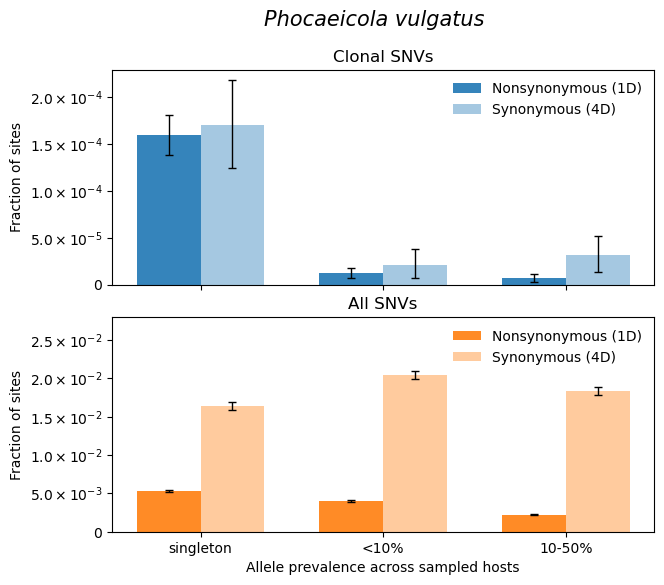

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import poisson
from statsmodels.stats.proportion import proportion_confint   # optional if you want Wilson

# ------------------------------------------------------------------
# 0️⃣  Recompute *counts* and *proportions*
# ------------------------------------------------------------------
order = ['singleton'] + freq_labels                # the bin order you already use

def counts_and_prop(series, total_sites):
    """Return (counts, prop) arrays in the fixed order."""
    counts = series.value_counts().reindex(order, fill_value=0).to_numpy()
    prop   = counts / total_sites
    return counts, prop

cnt_1d_clonal, prop_1d_clonal = counts_and_prop(cats_1d_clonal, L1d)
cnt_4d_clonal, prop_4d_clonal = counts_and_prop(cats_4d_clonal, L4d)
cnt_1d_all,    prop_1d_all    = counts_and_prop(cats_1d_all,    L1d)
cnt_4d_all,    prop_4d_all    = counts_and_prop(cats_4d_all,    L4d)

# ------------------------------------------------------------------
# 1️⃣  Helper: Poisson proportion error bars
# ------------------------------------------------------------------
def poisson_prop_err(counts, total, conf=0.95):
    """Return a (2, n) array of asymmetric errors for plt.errorbar."""
    lo, hi = poisson.interval(conf, counts)       # exact Poisson CI on counts
    prop   = counts / total
    lo_p   = prop - lo / total
    hi_p   = hi   / total - prop
    return np.vstack([lo_p, hi_p])

err_1d_clonal = poisson_prop_err(cnt_1d_clonal, L1d)
err_4d_clonal = poisson_prop_err(cnt_4d_clonal, L4d)
err_1d_all    = poisson_prop_err(cnt_1d_all,    L1d)
err_4d_all    = poisson_prop_err(cnt_4d_all,    L4d)

# ------------------------------------------------------------------
# 2️⃣  Plot – two stacked panels with error bars
# ------------------------------------------------------------------
x      = np.arange(len(order))
width  = 0.35

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(7, 6),
    sharex=True, gridspec_kw={'hspace': 0.15}
)

# ---- Panel A: Clonal ----
ax = axes[0]
ax.bar(x - width/2, prop_1d_clonal, width,
       label="Nonsynonymous (1D)", color="tab:blue", alpha=0.9)
ax.bar(x + width/2, prop_4d_clonal, width,
       label="Synonymous (4D)", color="tab:blue", alpha=0.4)

# Add error bars
ax.errorbar(x - width/2, prop_1d_clonal, yerr=err_1d_clonal,
            fmt='none', ecolor='k', capsize=3, lw=1)
ax.errorbar(x + width/2, prop_4d_clonal, yerr=err_4d_clonal,
            fmt='none', ecolor='k', capsize=3, lw=1)
# ax.errorbar(x - width/2, prop_1d_clonal, yerr=15/L1d,
#             fmt='none', ecolor='k', capsize=3, lw=1)
# ax.errorbar(x + width/2, prop_4d_clonal, yerr=7/L4d,
#             fmt='none', ecolor='k', capsize=3, lw=1)

ax.set_ylabel("Fraction of sites")
ax.set_title("Clonal SNVs")
ax.legend(frameon=False)

# ---- Panel B: All ----
ax = axes[1]
ax.bar(x - width/2, prop_1d_all, width,
       label="Nonsynonymous (1D)", color="tab:orange", alpha=0.9)
ax.bar(x + width/2, prop_4d_all, width,
       label="Synonymous (4D)", color="tab:orange", alpha=0.4)

ax.errorbar(x - width/2, prop_1d_all, yerr=err_1d_all,
            fmt='none', ecolor='k', capsize=3, lw=1)
ax.errorbar(x + width/2, prop_4d_all, yerr=err_4d_all,
            fmt='none', ecolor='k', capsize=3, lw=1)

ax.set_ylabel("Fraction of sites")
ax.set_xlabel("Allele prevalence across sampled hosts")
ax.set_title("All SNVs")
ax.legend(loc='upper right', frameon=False)

# ---- Cosmetics & show ----
axes[1].set_xticks(x)
axes[1].set_xticklabels(order)
axes[1].set_ylim(0, 0.028)

# Custom formatter
def sci_notation(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exponent
    return r"${:.1f}\times10^{{{}}}$".format(coeff, exponent)

axes[0].yaxis.set_major_formatter(FuncFormatter(sci_notation))
axes[1].yaxis.set_major_formatter(FuncFormatter(sci_notation))

fig.suptitle("Phocaeicola vulgatus", y=0.98, fontsize=15, fontstyle='italic')
fig.tight_layout()
fig.savefig(config.fig_path / 'Bv_pnps_by_freq.pdf', bbox_inches='tight')

# Extending to other species

In [17]:
species_res = {}
for species_name, grouped in passed_pairs.groupby("species_name"):
    if len(grouped) < 5:
        continue
    print(f"Processing {species_name} with {len(grouped)} pairs")
    species_clonal_pairs = passed_pairs.loc[species_name]

    # then keep one pair per clonal cluster
    snv_helper = snv_utils.SNVHelper(species_name, compute_bi_snvs=False, annotate=True)
    snv_helper.load_identical_block()

    # then filter to only one pair per clonal cluster 
    clonal_pairs = dedup_clonal_pairs(species_clonal_pairs, snv_helper)

    # find clonal SNVs
    samples = [x for tup in clonal_pairs for x in tup]
    unique_samples = list(set(samples))
    species_samples = snv_helper.samples
    
    included_samples = [sample for sample in unique_samples]
    for sample in species_samples:
        if sample in included_samples:
            continue
        # then check the distance to the included samples
        # access the identical block fraction matrix directly
        similarity = snv_helper.identical_block_frac.loc[included_samples, sample]
        # if any similarity is greater than 0.5, skip the sample
        if similarity.max() < 0.5:
            included_samples.append(sample)
            continue

    print("Num clonal pairs:", len(clonal_pairs))
    if len(clonal_pairs) < 5:
        print(f"Skipping {species_name} due to insufficient samples")
        continue
    print("Num included samples:", len(included_samples))
    sns.clustermap(snv_helper.identical_block_frac.loc[unique_samples, unique_samples])
    plt.savefig(f"2025-08-18_clonal_snvs/{species_name}_clonal_samples_clustermap.pdf", dpi=600, bbox_inches='tight')
    plt.close()

    # compute SNV stats
    species_res[species_name] = compute_snv_stats(snv_helper, clonal_pairs, included_samples)

Processing Akkermansia_muciniphila_55290 with 6 pairs
Num clonal pairs: 4
Skipping Akkermansia_muciniphila_55290 due to insufficient samples
Processing Alistipes_sp_60764 with 9 pairs


KeyboardInterrupt: 

In [ ]:
print(len(species_res))

12


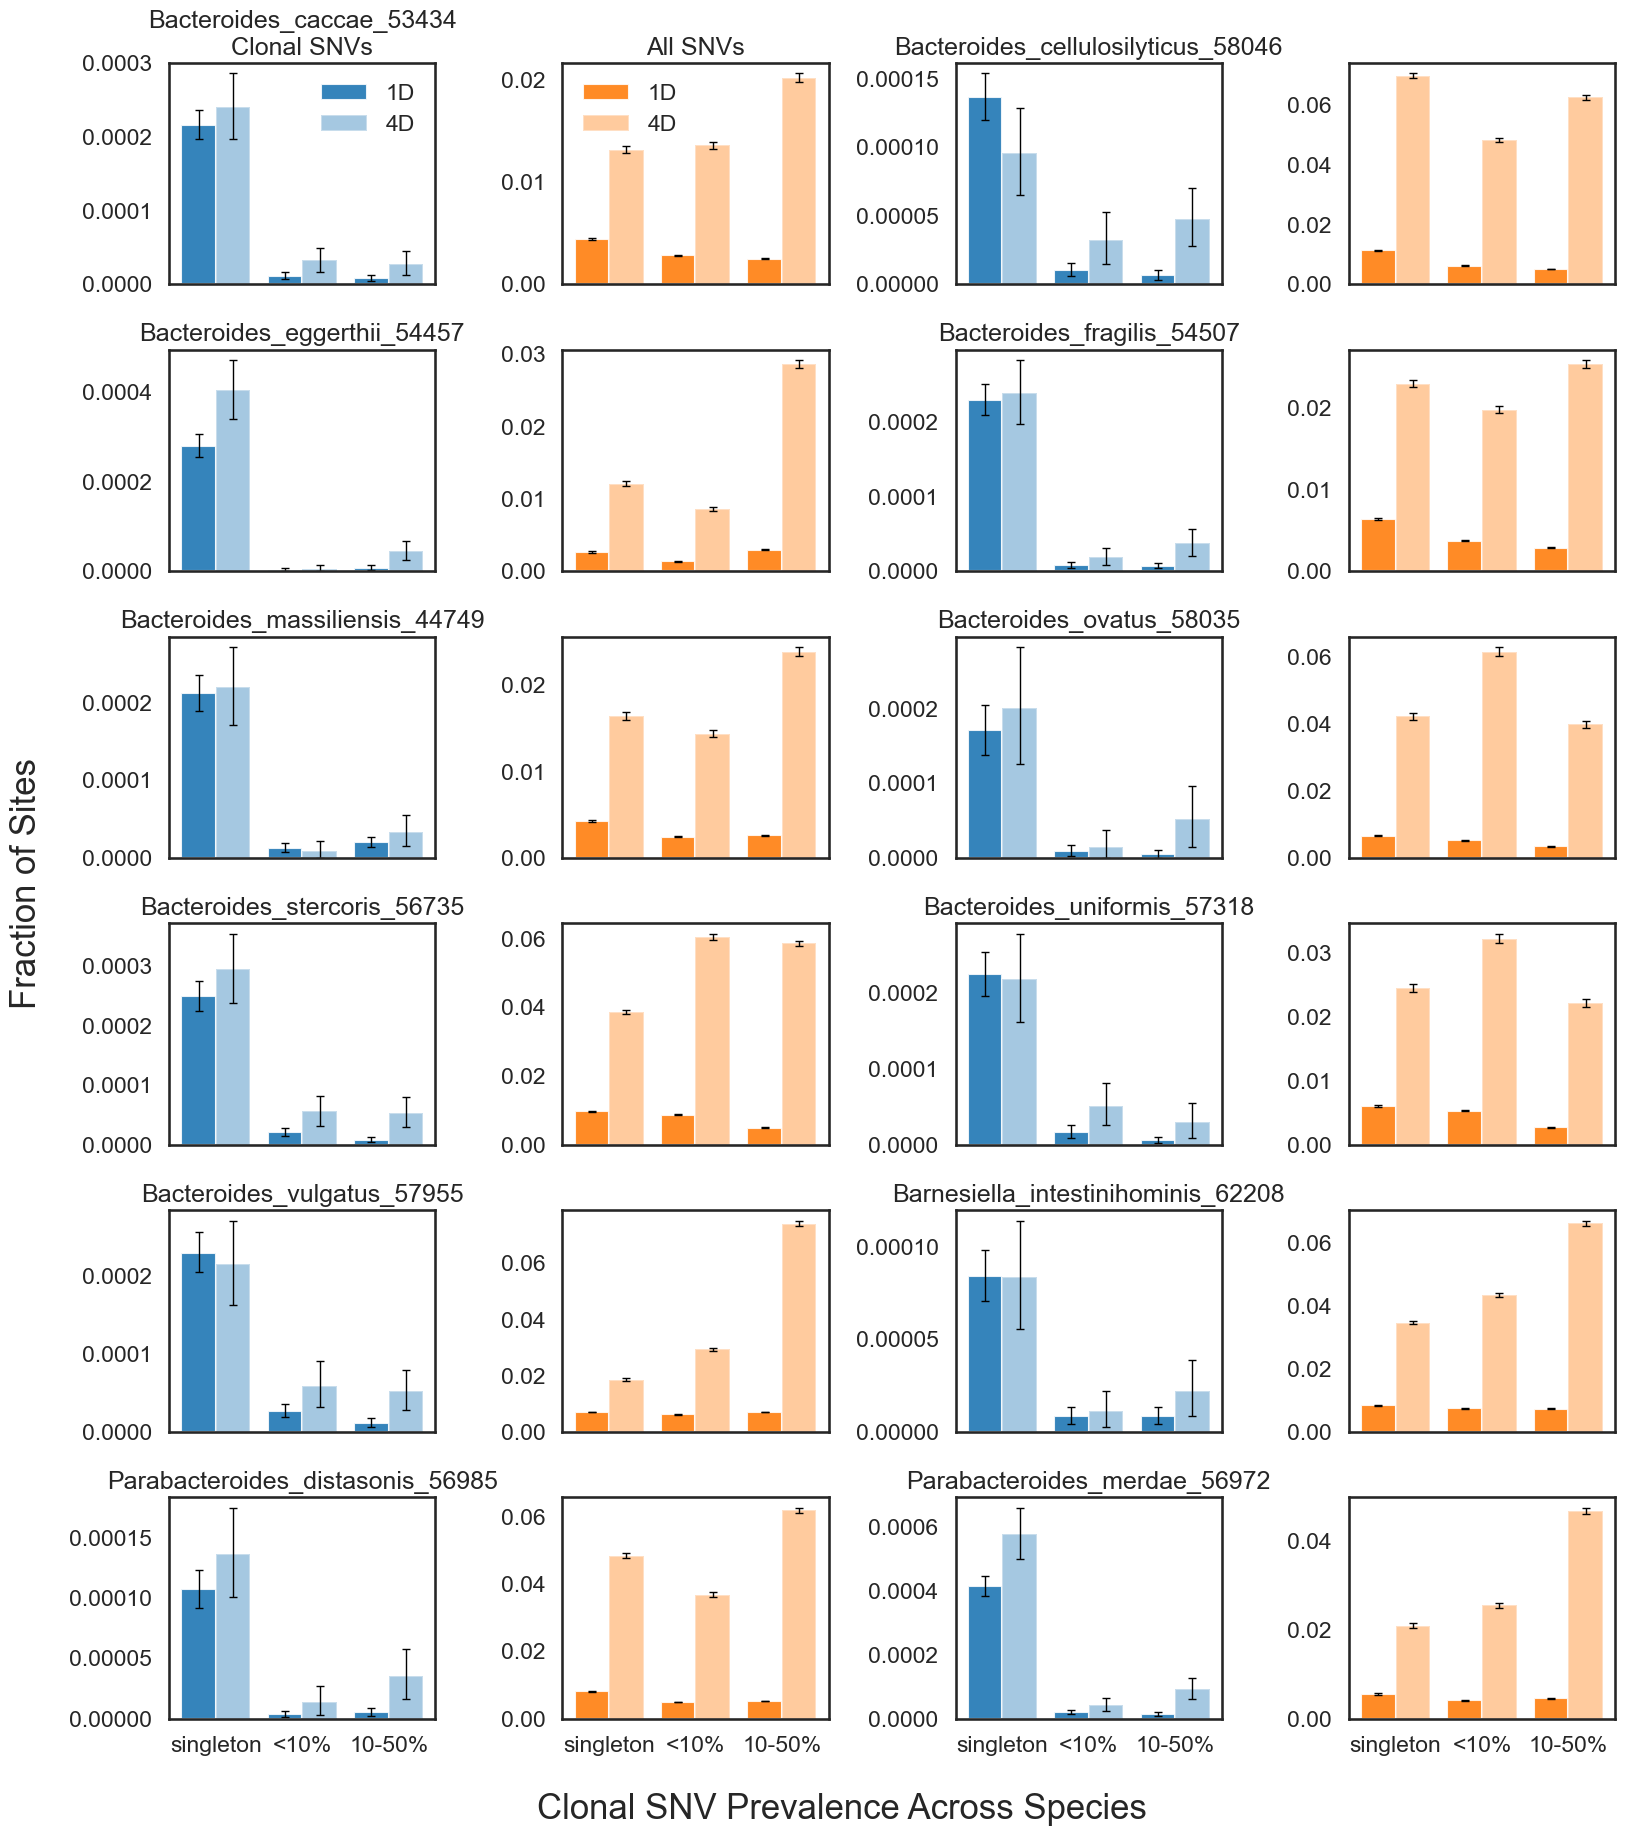

In [96]:
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white") 

def plot_snv_prevalence_grid_6x4(species_res, species_order=None, figsize=(16, 18)):
    """
    Plot a fixed 6x4 grid: two species per row, each species has two panels
    (Clonal, All). Any unused panels are hidden.
    """
    if species_order is None:
        species_order = sorted(species_res.keys())

    # Precompute everything
    prepped = {sp: _prep_one_species(species_res[sp]) for sp in species_order}

    # Common y-limit across all panels
    all_props = []
    for d in prepped.values():
        all_props.extend(d["prop_1d_clonal"])
        all_props.extend(d["prop_4d_clonal"])
        all_props.extend(d["prop_1d_all"])
        all_props.extend(d["prop_4d_all"])
    ymax = max(all_props) if all_props else 0.0
    ymax = 0.05 if ymax == 0 else min(1.0, ymax * 1.25)

    nrows, ncols = 6, 4  # fixed grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)
    x = np.arange(len(order))
    width = 0.40

    # Helper to draw one species into a column pair (c0 and c0+1) on row r
    def draw_species_at(sp, r, c0, show_xticks=False, show_legend=False):
        d = prepped[sp]
        # Left: Clonal
        ax = axes[r, c0]
        ax.bar(x - width/2, d["prop_1d_clonal"], width, label="1D", color="tab:blue",  alpha=0.90)
        ax.bar(x + width/2, d["prop_4d_clonal"], width, label="4D", color="tab:blue",  alpha=0.40)
        ax.errorbar(x - width/2, d["prop_1d_clonal"], yerr=d["err_1d_clonal"], fmt='none', ecolor='k', capsize=3, lw=1)
        ax.errorbar(x + width/2, d["prop_4d_clonal"], yerr=d["err_4d_clonal"], fmt='none', ecolor='k', capsize=3, lw=1)
        # if not np.isnan(d["private_1d_frac"]):
        #     ax.text(0.98, 0.92, f"private (1D): {d['private_1d_frac']:.1%}",
        #             transform=ax.transAxes, ha="right", va="top")
        ax.set_title(f"{sp}")

        # Right: All
        ax = axes[r, c0+1]
        ax.bar(x - width/2, d["prop_1d_all"], width, label="1D", color="tab:orange", alpha=0.90)
        ax.bar(x + width/2, d["prop_4d_all"], width, label="4D", color="tab:orange", alpha=0.40)
        ax.errorbar(x - width/2, d["prop_1d_all"], yerr=d["err_1d_all"], fmt='none', ecolor='k', capsize=3, lw=1)
        ax.errorbar(x + width/2, d["prop_4d_all"], yerr=d["err_4d_all"], fmt='none', ecolor='k', capsize=3, lw=1)
        # ax.set_title(f"{sp}\nAll SNVs")

        # X ticks
        if show_xticks:
            axes[r, c0].set_xticks(x);     axes[r, c0].set_xticklabels(order, rotation=0)
            axes[r, c0+1].set_xticks(x);   axes[r, c0+1].set_xticklabels(order, rotation=0)
            # axes[r, c0+1].set_xlabel("Allele prevalence across sampled hosts")
        else:
            axes[r, c0].set_xticks(x);     axes[r, c0].set_xticklabels([])
            axes[r, c0+1].set_xticks(x);   axes[r, c0+1].set_xticklabels([])

        if show_legend:
            axes[r, c0].set_title(f"{sp}\nClonal SNVs")
            axes[r, c0+1].set_title(f"All SNVs")
            for ax in (axes[r, c0], axes[r, c0+1]):
                ax.legend(frameon=False, loc="best")

    # Place species: two per row
    max_species_slots = nrows * (ncols // 2)  # 12
    used_slots = min(len(species_order), max_species_slots)
    for idx in range(used_slots):
        sp = species_order[idx]
        row = idx // 2
        colpair_start = (idx % 2) * 2  # (0,1) or (2,3)
        show_xticks = (row == nrows - 1)
        # show_xticks = (idx == 0)
        show_legend = (idx == 0) 
        draw_species_at(sp, row, colpair_start, show_xticks=show_xticks, show_legend=show_legend)

    # Hide any unused axes (including the last two panels when you have 11 species)
    total_panels = nrows * ncols  # 24
    used_panels = used_slots * 2  # two panels per species
    to_hide = total_panels - used_panels
    if to_hide > 0:
        # flatten in row-major order, hide from the end backwards
        flat_axes = axes.ravel()
        for ax in flat_axes[-to_hide:]:
            ax.axis('off')

    plt.tight_layout()
    return fig, axes

# ---- Example:
species_order = sorted(species_res.keys())  # or your custom order
fig, axes = plot_snv_prevalence_grid_6x4(species_res, species_order=species_order, figsize=(16, 18))
# axes[-1, 0].set_xlabel("Allele prevalence across sampled hosts")
fig.text(0.5, -0.02, "Clonal SNV Prevalence Across Species", ha='center', fontsize=25)
fig.text(-0.02, 0.5, "Fraction of Sites", va='center', rotation='vertical', fontsize=25)
plt.show()

fig.savefig(config.fig_path / "clonal_snv_prevalence_grid.pdf", dpi=600, bbox_inches='tight')
